In [2]:
import os, sys
import json
import pandas as pd

from tqdm import tqdm
from collections import Counter, defaultdict
from itertools import chain

from typing import List

### Book
- is_impossible = True 인 경우 제외 필요. 대답을 할 수 없는 질문임.

### News
- source

| 기입형태 | 해당 본문 카테고리 |
|:--------:|:------------------:|
| 1        | 정치               |
| 2        | 경제               |
| 3        | 사회               |
| 4        | 생활               |
| 5        | IT/과학            |
| 6        | 연예               |
| 7        | 스포츠             |
| 8        | 문화               |
| 9        | 미용/건강          |

- classtype

|  기입형태  | 해당 본문 카테고리 |
|:----------:|:------------------:|
| work_where | 어디서             |
| work_who   | 누가               |
| work_what  | 무엇을             |
| work_how   | 어떻게             |
| work_why   | 왜                 |
| work_when  | 언제               |

In [3]:
KORQUAD_PATH = '/home/ubuntu/workspace/kaist.ir/qa/data/korquad'
BOOKQA_PATH = '/home/ubuntu/workspace/kaist.ir/qa/data/bookqa'
NEWSQA_PATH = '/home/ubuntu/workspace/kaist.ir/qa/data/newsqa'

KORQUAD_TRAIN = 'KorQuAD_v1.0_train.json'
KORQUAD_TEST = 'KorQuAD_v1.0_dev.json'
BOOKQA_TRAIN = 'bookqa_train.json'
BOOKQA_TEST = 'bookqa_valid.json'
NEWS_ALL = 'ko_nia_normal_squad_all.json'

In [9]:
with open(os.path.join(KORQUAD_PATH, KORQUAD_TRAIN)) as f:
    korquad_train = json.load(f)

with open(os.path.join(KORQUAD_PATH, KORQUAD_TEST)) as f:
    korquad_test = json.load(f)

with open(os.path.join(BOOKQA_PATH, BOOKQA_TRAIN)) as f:
    bookqa_train = json.load(f)

with open(os.path.join(BOOKQA_PATH, BOOKQA_TEST)) as f:
    bookqa_test = json.load(f)

with open(os.path.join(NEWSQA_PATH, NEWS_ALL)) as f:
    news_all = json.load(f)

In [4]:
korquad_train['data'][0]['paragraphs'][0]

{'qas': [{'answers': [{'text': '교향곡', 'answer_start': 54}],
   'id': '6566495-0-0',
   'question': '바그너는 괴테의 파우스트를 읽고 무엇을 쓰고자 했는가?'},
  {'answers': [{'text': '1악장', 'answer_start': 421}],
   'id': '6566495-0-1',
   'question': '바그너는 교향곡 작곡을 어디까지 쓴 뒤에 중단했는가?'},
  {'answers': [{'text': '베토벤의 교향곡 9번', 'answer_start': 194}],
   'id': '6566495-0-2',
   'question': '바그너가 파우스트 서곡을 쓸 때 어떤 곡의 영향을 받았는가?'},
  {'answers': [{'text': '파우스트', 'answer_start': 15}],
   'id': '6566518-0-0',
   'question': '1839년 바그너가 교향곡의 소재로 쓰려고 했던 책은?'},
  {'answers': [{'text': '합창교향곡', 'answer_start': 354}],
   'id': '6566518-0-1',
   'question': '파우스트 서곡의 라단조 조성이 영향을 받은 베토벤의 곡은?'},
  {'answers': [{'text': '1839', 'answer_start': 0}],
   'id': '5917067-0-0',
   'question': '바그너가 파우스트를 처음으로 읽은 년도는?'},
  {'answers': [{'text': '파리', 'answer_start': 410}],
   'id': '5917067-0-1',
   'question': '바그너가 처음 교향곡 작곡을 한 장소는?'},
  {'answers': [{'text': '드레스덴', 'answer_start': 534}],
   'id': '5917067-0-2',
   'question': '바그너의 1

In [5]:
bookqa_train['data'][0]['paragraphs'][0]

{'context': '또한, 정책 및 사업의 본격 추진을 위한 재원의 확보 방안을 마련해야 한다. 특별법의 하위 법령 또는 관련 법령의 제·개정을 통해 불이행 행위자에 강제 이행 유도를 위한 벌금 또는 ‘오염 원인자 부담’의 원칙에 따른 ‘해양 대기오염 부담금(안)’을 부과할 수 있다. 부담금 징수로 인한 재정 수익분을 항만의 대기환경 개선을 위한 특별회계에서 수용하도록 하고, 예산의 배분에 있어서도 사업의 시급성, 파급 효과 등을 고려하여 사업의 우선순위에 차등을 두어 지원하는 ‘선택과 집중’의 전략적 방법론을 적용해야 한다. 이와 더불어 유관 부처 및 기관 등 주요 정책 행위자들의 업무 역할과 기능, 나아가 의무 및 권한의 범위 등에 대한 명확한 법적 근거 역시 시급하게 마련되어야 한다. 각 부처 및 기관별로 사업을 추진하고 개별성과를 기계적으로 취합하는 현재의 방식보다는, 통합 관리 차원에서 유관 부처·기관 간 공동 연구개발 및 조사, 공공 데이터 차원의 정보 연계·공유 및 활용 등을 통해 정책 및 사업의 효율성을 높이고, 공동의 사회 문제 해결을 위한 시너지의 도출이 필요하다.',
 'qas': [{'question': '예산을 분배할 때 사업의 우선 순위를 정해서 차등 지원하는 방법을 뭐라고 하지',
   'id': 1063333,
   'is_impossible': False,
   'answers': [{'text': '선택과 집중', 'answer_start': 260}]},
  {'question': '사업의 우선 순위를 정해서 예산을 차등적으로 나눠주는 방법을 뭐라고 해',
   'id': 1063334,
   'is_impossible': False,
   'answers': [{'text': '선택과 집중', 'answer_start': 260}]},
  {'question': '사업의 우선 순위로 예산을 차등 분배하는 방법을 뭐라고 불러',
   'id': 1063335,
   'is_impossible': False,
   'answ

In [6]:
news_all['data'][2]

{'title': '20180305114044000',
 'paragraphs': [{'context': '중국의 한 여성 경찰이 아파트에서 추락하던 3세 아이를 살리고 자신은 혼수상태에 빠졌습니다. 의인(義人)의 소식이 알려지자 각박한 중국 사회에 큰 반향을 일으키고 있습니다. 5일 귀주도시망 등 중국 현지 언론에 따르면 구이저우성 카일리시에 보조 교통 경찰로 일하는 천중핑(49)은 지난달 28일 한 아파트에서 비상 상황이 발생했다는 연락을 받고 현장으로 향했습니다. 도착했을 때 아파트 4층 창문에서 여자 아이가 매달려 있었습니다. 곧이어 아이는 손에 힘이 빠지면서 밑으로 추락했습니다. 천중핑과 다른 세명의 이웃들이 달려갔습니다. 그리고 아이는 바닥이 아니라 천중핑의 팔에 떨어졌습니다. 중간 비막이 천막 때문에 속도가 줄기는 했지만 추락의 충격은 천중핑이 고스란히 감당해야 했습니다. 아이는 즉시 병원으로 옮겨져 치료를 받았습니다. 다리 골절로 그리 심각한 상황은 아니라고 합니다. 하지만 생명의 은인이자 영웅은 커다란 댓가를 치러야 했다. 뇌출혈로 인한 의식불명 상태에 빠진 것이다. 다행히 이틀 간의 코마 상태 이후 의식을 회복해 지난 2일부터 중환자실에서 치료를 받고 있습니다. 아이는 열쇠공이 문을 따는 소리에 겁을 먹고 창문 밖으로 도망을 치려다 사고를 당한 것으로 전해졌습니다. 아이가 잠든 사이 돌보던 아이의 할머니가 쓰레기를 버리러 나갔다가 문이 잠기는 바람에 열쇠공을 불렀던 것입니다. 아이의 엄마는 “천중핑의 도움이 없었다면 아이는 죽었을 것”이라며 딸을 구해준 천중핑에게 감사의 뜻을 전했습다. 카일리시 정부 대표와 공안부 관계자들도 천중핑이 입원한 병원을 찾아 위로하고 회복될때까지 도움을 아끼지 않겠다고 밝혔습니다. 천중핑의 선행 사실을 접한 중국 기업 알리바바도 ‘중국의 좋은 이웃상’과 함께 상금 1만 위안(약 170만원)을 수여하기로 했습니다. [아직 살만한 세상]은 점점 각박해지는 세상에 희망과 믿음을 주는 이들의 이야기입니다. 힘들고 지칠 때

In [10]:
sources = [data['source'] for data in news_all['data']]
len(sources)

47314

In [11]:
src_id2cls = {1: '정치', 2: '경제', 3: '사회', 4: '생활', 5: 'IT/과학', 6: '연예', 7: '스포츠', 8: '문화', 9: '미용/건강'}

for k, v in dict(Counter(sources)).items():
    print(src_id2cls[k], '\t', v)

IT/과학 	 5017
스포츠 	 5021
생활 	 5765
사회 	 5625
경제 	 3981
연예 	 5091
미용/건강 	 4272
정치 	 7317
문화 	 5225


In [4]:
def extract_questions_and_answers(file_path, has_src=False):
  with open(file_path) as f:
    data = json.load(f)
  
  data_rows = []
  for doc in tqdm(data['data']):
    if has_src:
      source = doc['source']
    else:
      source = 'all'
    for paragraph in doc['paragraphs']:
      context = paragraph['context']
      for question_and_answers in paragraph['qas']:
        question = question_and_answers['question']
        answers = question_and_answers['answers']
        
        for answer in answers:
          answer_text = answer['text']
          answer_start = answer['answer_start']
          answer_end = answer_start + len(answer_text)

          data_rows.append({
            'question': question,
            'context': context,
            'answer_text': answer_text,
            'answer_start': answer_start,
            'answer_end': answer_end,
            'source': source
        })
  return pd.DataFrame(data_rows)

In [5]:
korquad_train = extract_questions_and_answers(os.path.join(KORQUAD_PATH, KORQUAD_TRAIN))
bookqa_train = extract_questions_and_answers(os.path.join(BOOKQA_PATH, BOOKQA_TRAIN))
news_all = extract_questions_and_answers(os.path.join(NEWSQA_PATH, NEWS_ALL), has_src=True)

100%|██████████| 47314/47314 [00:00<00:00, 182909.15it/s]


# PCA Vizualization of BERT output

In [12]:
korquad_contexts = []
for data in korquad_train['data']:
    for context_qas in data['paragraphs']:
        context = context_qas['context']
        korquad_contexts.append(context)

len(korquad_contexts)

9681

In [13]:
news_contexts = defaultdict(list)
for data in news_all['data']:
    source = data['source']
    for context_qas in data['paragraphs']:
        context = context_qas['context']
        news_contexts[source].append(context)

for k, v in news_contexts.items():
    print(k, len(v))

5 5017
7 5021
4 5765
3 5625
2 3981
6 5091
9 4272
1 7317
8 5225


In [6]:
book_contexts = []
for data in bookqa_train['data']:
    for context_qas in data['paragraphs']:
        context = context_qas['context']
        book_contexts.append(context)
len(book_contexts)

225000

In [35]:
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

import torch

from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel

In [6]:
model = AutoModel.from_pretrained("klue/bert-base")
tokenizer = AutoTokenizer.from_pretrained("klue/bert-base")

Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [14]:
def batch(iterable, n=64):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]

In [15]:
news_contexts_list = list(chain.from_iterable([v for k, v in news_contexts.items()]))
news_labels_list = list(chain.from_iterable([[k] * len(v) for k, v in news_contexts.items()]))
len(news_contexts_list)

47314

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

In [17]:
cls_token, train_masks, train_ys = torch.zeros(0, 768), torch.zeros(0, 512), torch.zeros(0,1)
span_length = 4
with torch.no_grad():
    for r in tqdm(batch(range(len(news_contexts_list)), n=span_length), total=(len(news_contexts_list)//span_length)+1):
        batch_contexts, batch_labels = news_contexts_list[r[0]:r[-1]], news_labels_list[r[0]:r[-1]]
        encodings = tokenizer(batch_contexts,
                            max_length=512,
                            truncation=True,
                            padding='max_length',
                            return_attention_mask=True,
                            return_tensors='pt')
        output = model(encodings['input_ids'].to(device), encodings['attention_mask'].to(device), output_hidden_states=True, return_dict=True)
        cls_token = torch.cat([cls_token, output.last_hidden_state[:,0,:].cpu()])
        #train_masks = torch.cat([train_masks, encodings['attention_mask'].cpu()])
        train_ys = torch.cat([train_ys, torch.tensor(batch_labels).cpu().view(-1,1)])

100%|██████████| 11829/11829 [18:21<00:00, 10.74it/s]


In [18]:
Counter(train_ys.squeeze().numpy().tolist())

Counter({5.0: 3763,
         7.0: 3766,
         4.0: 4324,
         3.0: 4218,
         2.0: 2986,
         6.0: 3818,
         9.0: 3204,
         1.0: 5488,
         8.0: 3918})

In [19]:
dim_reducer = TSNE(n_components=2)
# averaged_layer_hidden_states = torch.div(layer_hidden_states.sum(dim=1), train_masks.sum(dim=1,keepdim=True))
layer_dim_reduced_vectors = dim_reducer.fit_transform(cls_token.detach().numpy())
df = pd.DataFrame.from_dict({'x':layer_dim_reduced_vectors[:,0],'y':layer_dim_reduced_vectors[:,1],'label':train_ys.squeeze()})
df.label = df.label.astype(int)
df

/home/ubuntu/anaconda3/envs/ir/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/ubuntu/anaconda3/envs/ir/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


,x,y,label
0,11.076500,-1.291866,5
1,-17.110722,0.209754,5
2,-47.282864,-7.722584,5
3,41.982437,16.556686,5
4,43.848850,15.162859,5
...,...,...,...
35480,-0.863062,-35.764702,8
35481,10.867757,-56.259861,8
35482,11.565045,74.315536,8
35483,62.433628,-13.470034,8


In [21]:
df['label'] = df['label'].apply(lambda x: src_id2cls[x])
df.head()

,x,y,label
0,11.076500,-1.291866,IT/과학
1,-17.110722,0.209754,IT/과학
2,-47.282864,-7.722584,IT/과학
3,41.982437,16.556686,IT/과학
4,43.848850,15.162859,IT/과학


In [55]:
import importlib
importlib.reload(matplotlib)

<module 'matplotlib' from '/home/ubuntu/anaconda3/envs/ir/lib/python3.7/site-packages/matplotlib/__init__.py'>

In [51]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

path = '/usr/share/fonts/truetype/nanum/NanumGothicCoding.ttf'
fontprop = fm.FontProperties(fname=path, size=18)

In [ ]:
plt.figure(figsize=(10, 10))
# plt.rcParams["font.family"] = 'NanumGothic'
plt.scatter(x=df['x'], y=df['y'], s=df['label'], fontproperties=fontprop)
# sns.scatterplot(data=df, x='x',y='y',hue='label', fontproperties=fontprop)

# import matplotlib.pyplot as plt
# import matplotlib.font_manager as fm

# path = '/usr/share/fonts/truetype/nanum/NanumGothicCoding.ttf'
# fontprop = fm.FontProperties(fname=path, size=18)

# plt.plot(range(50), data, 'r')
# plt.title('가격변동 추이', fontproperties=fontprop)
# plt.ylabel('가격', fontproperties=fontprop)
# plt.show()

In [63]:
df.to_csv('../result/news_tsne_noavg.csv', index=False)

In [15]:
total_contexts = korquad_contexts + list(chain.from_iterable([v for k, v in news_contexts.items()]))
total_labels = [0] * len(korquad_contexts) + list(chain.from_iterable([[k] * len(v) for k, v in news_contexts.items()]))
len(total_contexts)

56995

In [30]:
encodings = tokenizer(total_contexts,
                      max_length=512,
                      truncation=True,
                      padding='max_length',
                      return_attention_mask=True,
                      return_tensors='pt')

In [9]:
# test = bookqa_train['data'][0]['paragraphs'][0]['context']
# test
samples = [context['context'] for context in bookqa_train['data'][0]['paragraphs']]
samples

['또한, 정책 및 사업의 본격 추진을 위한 재원의 확보 방안을 마련해야 한다. 특별법의 하위 법령 또는 관련 법령의 제·개정을 통해 불이행 행위자에 강제 이행 유도를 위한 벌금 또는 ‘오염 원인자 부담’의 원칙에 따른 ‘해양 대기오염 부담금(안)’을 부과할 수 있다. 부담금 징수로 인한 재정 수익분을 항만의 대기환경 개선을 위한 특별회계에서 수용하도록 하고, 예산의 배분에 있어서도 사업의 시급성, 파급 효과 등을 고려하여 사업의 우선순위에 차등을 두어 지원하는 ‘선택과 집중’의 전략적 방법론을 적용해야 한다. 이와 더불어 유관 부처 및 기관 등 주요 정책 행위자들의 업무 역할과 기능, 나아가 의무 및 권한의 범위 등에 대한 명확한 법적 근거 역시 시급하게 마련되어야 한다. 각 부처 및 기관별로 사업을 추진하고 개별성과를 기계적으로 취합하는 현재의 방식보다는, 통합 관리 차원에서 유관 부처·기관 간 공동 연구개발 및 조사, 공공 데이터 차원의 정보 연계·공유 및 활용 등을 통해 정책 및 사업의 효율성을 높이고, 공동의 사회 문제 해결을 위한 시너지의 도출이 필요하다.',
 '최근 국민적 관심에 힘입어 미세먼지 등 대기오염 문제가 커다란 사회적 현안으로 등장하고 있다. 특히 대형 선박의 입출항 및 정박은 물론 하역, 운송 등의 활동이 이루어지는 항만은 오랜 시간 동안 배출관리의 사각지대에 남아있었으나, 항만 인근 지역은 물론 국가 대기오염의 주된 원인으로 지목되고 있다. 해마다 환경부가 발표하는 ‘국가 대기오염물질 배출량 통계’에서 국가 전체 배출량 중 선박에 의한 배출 비중이 매우 높게 나타나고 있으며 주요 항만을 포함하는 지역의 선박 배출량 규모 역시 매우 크게 나타나고 있기 때문이다. 항만의 배출저감 및 관리를 위한 대책이 시급한 이유가 여기에 있다. 이에, 환경부는 미세먼지 및 미세먼지 생성물질의 배출을 저감하고 종합적으로 관리하기 위한 「미세먼지 저감 및 관리에 관한 특별법」을 제정하여 지난 2월부터 시행 중이다. 해양수산부 역시 항만 및 인근 영향지역

In [ ]:
device = "cuda" if torch.is_available() else "cpu"
model = model.to(device)

In [29]:
train_masks, train_ys = torch.zeros(0, 512), torch.zeros(0,1)
train_hidden_states = None
span_length = 64
for r in tqdm(batch(range(len(total_labels)), n=span_length), total=(len(total_labels)//span_length)+1):
    batch_contexts, batch_labels = total_contexts[r[0]:r[-1]], total_labels[r[0]:r[-1]]
    encodings = tokenizer(batch_contexts,
                        max_length=512,
                        truncation=True,
                        padding='max_length',
                        return_attention_mask=True,
                        return_tensors='pt')
    output = model(encodings['input_ids'].to(device), encodings['attention_mask'].to(device), output_hidden_states=True, return_dict=True)
    hidden_states = output.hidden_states[1: ]
    train_masks = torch.cat([train_masks, encodings['attention_mask'].cpu()])
    train_ys = torch.cat([train_ys, torch.tensor(batch_labels).cpu().view(-1,1)])
    if type(train_hidden_states) == type(None):
        train_hidden_states = tuple(layer_hidden_states.cpu() for layer_hidden_states in hidden_states)
    else:
        train_hidden_states = tuple(torch.cat([layer_hidden_state_all, layer_hidden_state_batch.cpu()])for layer_hidden_state_all, layer_hidden_state_batch in zip(train_hidden_states, hidden_states))

  0%|          | 1/891.546875 [00:40<9:57:17, 40.24s/it]

In [ ]:
train_hidden_states.shape

In [10]:
test_encoding = tokenizer(samples,
                          max_length=512,
                          truncation=True,
                          padding='max_length',
                          return_attention_mask=True,
                          return_tensors='pt')


In [27]:
train_masks, train_ys = torch.zeros(0, 512), torch.zeros(0,1)

In [22]:
output = model(test_encoding['input_ids'], test_encoding['attention_mask'], output_hidden_states=True, return_dict=True)
hidden_states = output.hidden_states[1:]
train_hidden_states = tuple(layer_hidden_states.cpu() for layer_hidden_states in hidden_states)
train_masks = torch.cat([train_masks, test_encoding['attention_mask'].cpu()])
train_ys = torch.cat([train_ys, torch.tensor([0, 0, 0]).cpu().view(-1,1)])

In [25]:
output.last_hidden_state[:,0,:].detach().numpy()

array([[ 0.37499854,  0.30711803, -0.22767217, ..., -0.27081186,
        -0.04755132,  0.52785164],
       [-0.15950038, -0.1044018 , -0.43394968, ...,  0.67631674,
         0.20772135,  0.32073516],
       [-0.36717808,  0.33571374, -0.3536198 , ...,  0.58097416,
         0.05888833,  0.15914038]], dtype=float32)

In [28]:
dim_reducer = TSNE(n_components=2)
layer_hidden_states = train_hidden_states[11]
averaged_layer_hidden_states = torch.div(layer_hidden_states.sum(dim=1), train_masks.sum(dim=1,keepdim=True))
layer_dim_reduced_vectors = dim_reducer.fit_transform(averaged_layer_hidden_states.detach().numpy())
df = pd.DataFrame.from_dict({'x':layer_dim_reduced_vectors[:,0],'y':layer_dim_reduced_vectors[:,1],'label':train_ys.squeeze()})
df.label = df.label.astype(int)
df

RuntimeError: The size of tensor a (3) must match the size of tensor b (0) at non-singleton dimension 0

<AxesSubplot:xlabel='x', ylabel='y'>

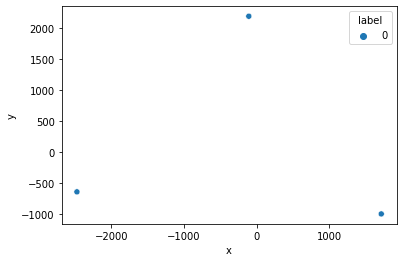

In [80]:
sns.scatterplot(data=df,x='x',y='y',hue='label')

# Sequence Check

In [2]:
import json
from collections import defaultdict
from tqdm import tqdm
import pandas as pd

from transformers import AutoTokenizer

In [2]:
def read_file(file_path, is_source=False, source_no="all"):
    with open(file_path) as f:
        data = json.load(f)

    qa_data = defaultdict(list)
    for doc in data['data']:
        if is_source:
            source = doc['source']
        else:
            source = "all"
        filtered = True if source == source_no else False
        if filtered:
            for paragraph in doc['paragraphs']:
                context = paragraph['context'].replace('\u200b', '')
                for question_and_answers in paragraph['qas']:
                    is_impossible = question_and_answers['is_impossible'] if 'is_impossible' in question_and_answers else None
                    if not is_impossible:
                        question = question_and_answers['question']
                        answers = question_and_answers['answers']    
                        for answer in answers:
                            qa_data['context'].append(context)
                            qa_data['question'].append(question)
                            qa_data['answers'].append(answer)
                            if is_source:
                                qa_data['source'].append(source)
    return qa_data

In [4]:
tokenizer = AutoTokenizer.from_pretrained("klue/bert-base")

In [7]:
data_path = '/home/ubuntu/workspace/kaist.ir/qa/data'
squad_train_data = read_file(os.path.join(data_path, 'korquad/KorQuAD_v1.0_train.json'))
squad_valid_data = read_file(os.path.join(data_path, 'korquad/KorQuAD_v1.0_dev.json'))

In [42]:
train_hub_data = read_file(os.path.join(data_path, 'newsqa/news_train_all_10.json'))
valid_hub_data = read_file(os.path.join(data_path, 'newsqa/news_test_all_10.json'))

In [24]:
test_valid_data = defaultdict(list)
for question, context, answer in zip(squad_valid_data['question'], squad_valid_data['context'], squad_valid_data['answers']):
    if len(context) > 1000:
        test_valid_data['question'].append(question)
        test_valid_data['context'].append(context)
        test_valid_data['answers'].append(answer)

In [25]:
len(test_valid_data['question'])

233

In [37]:
qa_data = test_valid_data
max_len=512
doc_stride=0

encodings = []
long_cnt = 0
in_answer = 0
for context, question in tqdm(zip(qa_data['context'], qa_data['question']), total=len(qa_data['context'])):
    encoding = tokenizer(
        question,
        context,
        truncation="only_second",
        max_length=max_len,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length"
    )
    if len(encoding['input_ids']) > 1:
        cnt += 1
    sample_mapping = encoding.pop("overflow_to_sample_mapping")
    offset_mapping = encoding.pop("offset_mapping")

    encoding["start_positions"] = []
    encoding["end_positions"] = []
    
    for i, offsets in enumerate(offset_mapping):
        input_ids = encoding["input_ids"][i]
        cls_index = input_ids.index(tokenizer.cls_token_id)
        sequence_ids = encoding.sequence_ids(i)
        sample_index = sample_mapping[i]
        answers = qa_data['answers'][sample_index]
        start_char = answers['answer_start']
        end_char = start_char + len(answers['text'])

        token_start_index = 0
        while sequence_ids[token_start_index] != 1:
            token_start_index += 1

        token_end_index = len(input_ids) - 1
        while sequence_ids[token_end_index] != 1:
            token_end_index -= 1

        if not (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char):
            encoding["start_positions"].append(cls_index)
            encoding["end_positions"].append(cls_index)
        else:
            while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
                token_start_index += 1
            encoding["start_positions"].append(token_start_index - 1)
            while offsets[token_end_index][1] >= end_char:
                token_end_index -= 1
            encoding["end_positions"].append(token_end_index + 1)
    # has_start_idx = [idx for idx, sp in enumerate(encoding['start_positions']) if sp != cls_index]
    # has_end_idx = [idx for idx, ep in enumerate(encoding['end_positions']) if ep != cls_index]

    # if has_start_idx == has_end_idx and len(has_start_idx) != 0:
    #     has_idx = has_start_idx[0]
    #     ft_encodings = {k: v[has_idx] for k, v in encoding.items()}
    #     encodings.append(ft_encodings)
    # if len(encoding['input_ids']) > 2:
    #     break
    # # del encoding

  6%|▌         | 14/233 [00:00<00:00, 419.48it/s]


In [110]:
qa_data = squad_valid_data
max_len=512
doc_stride=0

encodings = []
long_cnt = 0
in_answer = 0
for context, question, answers in tqdm(zip(qa_data['context'], qa_data['question'], qa_data['answers']), total=len(qa_data['context'])):
    encoding = tokenizer(
        question,
        context,
        max_length=max_len,
        return_offsets_mapping=True,
        truncation=True,
        padding="max_length"
    )
    offset_mapping = encoding.pop("offset_mapping")

    encoding["start_positions"] = []
    encoding["end_positions"] = []
    
    input_ids = encoding['input_ids']
    cls_index = input_ids.index(tokenizer.cls_token_id)
    sequence_ids = encoding.sequence_ids(0)
    
    start_char = answers['answer_start']
    end_char = start_char + len(answers['text'])

    token_start_index = 0
    while sequence_ids[token_start_index] != 1:
        token_start_index += 1

    token_end_index = len(input_ids) - 1
    while sequence_ids[token_end_index] != 1:
        token_end_index -= 1
    
    if not (offset_mapping[token_start_index][0] <= start_char and offset_mapping[token_end_index][1] >= end_char):
        encoding["start_positions"].append(cls_index)
        encoding["end_positions"].append(cls_index)
        
    else:
        while token_start_index < len(offset_mapping) and offset_mapping[token_start_index][0] <= start_char:
            token_start_index += 1
        encoding["start_positions"].append(token_start_index - 1)
        while offset_mapping[token_end_index][1] >= end_char:
            token_end_index -= 1
        encoding["end_positions"].append(token_end_index + 1)
        in_answer += 1 

100%|██████████| 5774/5774 [00:06<00:00, 873.35it/s]


In [111]:
print(in_answer)

5717


In [70]:
offset_mapping[token_start_index]

(18, 19)

In [71]:
offset_mapping[token_end_index]

(18, 19)

In [72]:
print(token_start_index, token_end_index)

38 38


In [73]:
print(sequence_ids)

[None, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, None, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, 

In [74]:
print(encoding['start_positions'], encoding['end_positions'])

[37] [39]


In [76]:
def extract_questions_and_answers(file_path):
  with open(file_path) as f:
    data = json.load(f)
  
  data_rows = []
  for doc in data['data']:
    for paragraph in doc['paragraphs']:
      context = paragraph['context']
      for question_and_answers in paragraph['qas']:
        question = question_and_answers['question']
        answers = question_and_answers['answers']
        
        for answer in answers:
          answer_text = answer['text']
          answer_start = answer['answer_start']
          answer_end = answer_start + len(answer_text)

          data_rows.append({
            'question': question,
            'context': context,
            'answer_text': answer_text,
            'answer_start': answer_start,
            'answer_end': answer_end
        })
  return pd.DataFrame(data_rows)

In [77]:
data_path = '/home/ubuntu/workspace/kaist.ir/qa/data'
kor_train = extract_questions_and_answers(os.path.join(data_path, 'korquad/KorQuAD_v1.0_train.json'))
kor_valid = extract_questions_and_answers(os.path.join(data_path, 'korquad/KorQuAD_v1.0_dev.json'))

In [78]:
news_train = extract_questions_and_answers(os.path.join(data_path, 'newsqa/news_train_all_10.json'))
news_valid = extract_questions_and_answers(os.path.join(data_path, 'newsqa/news_test_all_10.json'))

In [80]:
news_train[news_train['answer_end'] > 500]

,question,context,answer_text,answer_start,answer_end
15,5년 전 93억원 규모였던 시장이 지난해 400억원 규모로 커졌고 5년 뒤에는 15...,"""오늘 전국이 25도 안팎의 날씨를 보였죠. 기온이 26도 정도가 되면 맥주의 매출...",수제맥주협회,768,774
16,소규모 맥주 면허는 언제 102개로 늘었는가?,"""오늘 전국이 25도 안팎의 날씨를 보였죠. 기온이 26도 정도가 되면 맥주의 매출...",지난 3월,749,754
19,수제맥주를 대부분 다품종 소량 생산하는 이유는?,"""오늘 전국이 25도 안팎의 날씨를 보였죠. 기온이 26도 정도가 되면 맥주의 매출...",양조장이 작아서,549,557
21,밀맥주는 발효 과정에 무엇을 넣어 만드는 맥주인가?,"""오늘 전국이 25도 안팎의 날씨를 보였죠. 기온이 26도 정도가 되면 맥주의 매출...",국화,505,507
22,6년 전 영국의 경제전문 기자는 어떤 칼럼을 게재했나?,"""오늘 전국이 25도 안팎의 날씨를 보였죠. 기온이 26도 정도가 되면 맥주의 매출...",&한국 맥주는 북한의 대동강맥주보다 맛이 없다&는 내용의 칼럼,959,993
...,...,...,...,...,...
220205,경찰은 수사권에 대해 무슨 주장을 했어?,검찰과 경찰의 수사권 갈등이 원만하게 해결되었다더니 문제가 더 꼬여가는 모양이다. ...,이제 자질향상이 이루어졌으니 수사권 일부를 달라는 주장이었다.,847,881
220206,"검찰이 수사지휘권을 더 확고하게 다진 반면, 경찰은 어떤 평가를 했어?",검찰과 경찰의 수사권 갈등이 원만하게 해결되었다더니 문제가 더 꼬여가는 모양이다. ...,지금까지 누려온 권한을 명문화시킨 명분상의 이익을 얻었다는 평가였다.,1036,1074
220216,JYJ는 ‘2011 JYJ WORLD TOUR CONCERT’를 성공리에 마감했으며...,[IMG1]JYJ의 김재중이 ‘시티헌터’ 후속으로 SBS에서 방송되는 수목극 ‘보스...,오는 26일 일요일 저녁 7시 광주광역시 염주종합체육관에서 앵콜 콘서트를 가진다.,586,631
220228,"사우디아라비아의 상업영화 상영 허용 후, 앞으로 무엇을 계획하고 있나요?","""사우디아라비아가 35년 만에 상업영화 상영을 허용했습니다. 보수 이슬람 정책의 빗...",2030년까지 복합상영관 300곳을 새로 짓고 3만 개의 일자리를 창출할 계획,511,554


In [95]:
encoding = tokenizer(
        news_train.loc[220206, 'question'],
        news_train.loc[220206, 'context'],
        max_length=max_len,
        truncation=True,
        return_offsets_mapping=True,
        padding="max_length"
    )
offset_mapping = encoding.pop("offset_mapping")

encoding["start_positions"] = []
encoding["end_positions"] = []

input_ids = encoding['input_ids']
cls_index = input_ids.index(tokenizer.cls_token_id)
sequence_ids = encoding.sequence_ids(0)

In [96]:
token_start_index = 0
while sequence_ids[token_start_index] != 1:
    token_start_index += 1

token_end_index = len(input_ids) - 1
while sequence_ids[token_end_index] != 1:
    token_end_index -= 1

In [97]:
print(token_start_index, token_end_index)

23 510


In [98]:
start_char = news_train.loc[220206, 'answer_start']
end_char = news_train.loc[220206, 'answer_end']
print(start_char, end_char)

1036 1074


In [100]:
offset_mapping[token_end_index]

(938, 939)

In [101]:
if not (offset_mapping[token_start_index][0] <= start_char and offset_mapping[token_end_index][1] >= end_char):
    encoding["start_positions"].append(cls_index)
    encoding["end_positions"].append(cls_index)
    print('y')
    
else:
    while token_start_index < len(offset_mapping) and offset_mapping[token_start_index][0] <= start_char:
        token_start_index += 1
    encoding["start_positions"].append(token_start_index - 1)
    while offset_mapping[token_end_index][1] >= end_char:
        token_end_index -= 1
    encoding["end_positions"].append(token_end_index + 1)
    print('n')


y


# TFIDF

In [9]:
from pororo import Pororo
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from itertools import chain

In [10]:
pos = Pororo(task="pos", lang="ko")

In [15]:
korquad_contexts = list(set(korquad_train['context']))
book_contexts = list(set(bookqa_train['context']))
news_contexts = list(set(news_all['context']))

print(len(korquad_contexts))
print(len(book_contexts))
print(len(news_contexts))

9606
173922
45464


In [59]:
ft_news_contexts = list(set(news_all[news_all['source'] == 9]['context']))
print(len(ft_news_contexts))

4110


In [16]:
def getNN(contexts: List[str], min: int):
    nn_contexts = []
    all_nns = []
    for context in tqdm(contexts, total=len(contexts)):
        pos_result = pos(context)
        tmp = []
        for result in pos_result:
            if len(result[0]) > 1 and result[1] in ['NNG', 'NNP']:
                all_nns.append(result[0])
                tmp.append(result[0])
        nn_contexts.append(tmp)
    nns = Counter(all_nns)
    ft_nn_contexts = []
    for context in nn_contexts:
        tmp = []
        for nn in context:
            if nns[nn] > min:
                tmp.append(nn)
        ft_nn_contexts.append(' '.join(tmp))

    return ft_nn_contexts


In [17]:
korquad_nn_contexts = getNN(korquad_contexts, min=5)

100%|██████████| 9606/9606 [00:26<00:00, 365.66it/s]


In [18]:
news_nn_contexts = getNN(news_contexts, min=5)

100%|██████████| 45464/45464 [03:43<00:00, 203.66it/s]


In [19]:
book_nn_contexts = getNN(book_contexts, min=5)

100%|██████████| 173922/173922 [07:54<00:00, 366.50it/s]


In [60]:
ft_news_nn_contexts = getNN(ft_news_contexts, min=5)

100%|██████████| 4110/4110 [00:20<00:00, 196.90it/s]


In [21]:
def getTopN(corpus: List[str], method: str, n: int):
    result = dict()
    if method == 'common':
        all_contexts = []
        for c in corpus:
            all_contexts.append(c.split())
        commons = Counter(list(chain.from_iterable(all_contexts))).most_common(n)
        for common in commons:
            result[common[0]] = common[1]
    elif method == 'tfidf':
        vectorizer = TfidfVectorizer()
        X = vectorizer.fit_transform(corpus)
        features = np.array(vectorizer.get_feature_names_out())
        sorting = np.argsort(X.toarray()).flatten()[::-1]
        top_n = features[sorting][:n]
        scores = np.sort(X.data)[:-(n+1):-1]
        for word, score in zip(top_n, scores):
            result[word] = score    
    return result

In [61]:
result = getTopN(ft_news_nn_contexts, method='common', n=20)
pd.DataFrame([[k, v] for k,v in result.items()])

,0,1
0,병원,3622
1,치료,2643
2,건강,2607
3,대통령,2560
4,환자,2506
5,의료,2432
6,경우,2229
7,기자,2147
8,조사,2028
9,서울,1946


In [34]:
pd.DataFrame([[k, v] for k,v in result.items()])

,0,1
0,대통령,17776
1,의원,11140
2,회담,8842
3,위원,8765
4,대표,8045
5,북한,7978
6,미국,6654
7,정부,6532
8,민주,6165
9,정상,6035


In [20]:
result = getTopN(news_nn_contexts, method='tfidf', n=10)
result

In [24]:
vectorizer = TfidfVectorizer()
korquad_X = vectorizer.fit_transform(korquad_nn_contexts)

In [31]:
features = np.array(vectorizer.get_feature_names_out())
sorting = np.argsort(korquad_X.toarray()).flatten()[::-1]

/home/ubuntu/anaconda3/envs/pororo/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
n = 10
top_n = features[sorting][:10]

Error: Session cannot generate requests

In [47]:
np.sort(korquad_X.data)[:-11:-1]

array([0.95003123, 0.94446449, 0.92270358, 0.91227676, 0.90834932,
       0.90688766, 0.90406433, 0.90242535, 0.89777629, 0.89683016])

# Bookdata

In [3]:
import json
from collections import defaultdict, Counter
import hashlib
import random
import pickle
from tqdm import tqdm

from transformers import  AutoTokenizer

In [5]:
class InputFeature():
    """A single set of features of data"""

    def __init__(self,
                 id,
                 input_ids,
                 token_type_ids,
                 attention_mask,
                 start_positions,
                 end_positions,
                 offset_mapping,
                 source=None
                 ):
        self.id = id
        self.input_ids = input_ids
        self.token_type_ids = token_type_ids
        self.attention_mask = attention_mask
        self.start_positions = start_positions
        self.end_positions = end_positions
        self.offset_mapping = offset_mapping
        self.source = source


def read_file(file_path, has_src=False):
    with open(file_path) as f:
        data = json.load(f)

    qa_data = defaultdict(list)
    for doc in data['data']:
        if has_src:
            source = doc['source']
        else:
            source = "all"
        for paragraph in doc['paragraphs']:
            context = paragraph['context'].replace('\u200b', '')
            for question_and_answers in paragraph['qas']:
                is_impossible = question_and_answers['is_impossible'] if 'is_impossible' in question_and_answers else None
                if not is_impossible:
                    question = question_and_answers['question']
                    answers = question_and_answers['answers']
                    for answer in answers:
                        id = question + context
                        id = hashlib.shake_256(id.encode()).hexdigest(5)
                        qa_data['id'].append(id)
                        qa_data['context'].append(context)
                        qa_data['question'].append(question)
                        qa_data['answers'].append(answer)
                        if has_src:
                            qa_data['source'].append(source)
    return qa_data


def convert_to_features(qa_data, tokenizer, max_len, has_src=False):
    encodings = []
    for idx, (id, context, question, answers) in tqdm(enumerate(zip(qa_data['id'],
                                                                    qa_data['context'],
                                                                    qa_data['question'],
                                                                    qa_data['answers'])), total=len(qa_data['context'])):
        encoding = tokenizer(
            question,
            context,
            truncation=True,
            max_length=max_len,
            return_offsets_mapping=True,
            padding="max_length"
        )
        encoding['id'] = id
        if has_src:
            encoding['source'] = qa_data['source'][idx]
        else:
            encoding['source'] = None
        offset_mapping = encoding.pop("offset_mapping")
        encoding['offset_mapping'] = offset_mapping

        input_ids = encoding['input_ids']
        sequence_ids = encoding.sequence_ids(0)

        start_char = answers['answer_start']
        end_char = start_char + len(answers['text'])

        token_start_index = 0
        while sequence_ids[token_start_index] != 1:
            token_start_index += 1

        token_end_index = len(input_ids) - 1
        while sequence_ids[token_end_index] != 1:
            token_end_index -= 1

        if offset_mapping[token_start_index][0] <= start_char and offset_mapping[token_end_index][1] >= end_char:
            while token_start_index < len(offset_mapping) and offset_mapping[token_start_index][0] <= start_char:
                token_start_index += 1
            encoding["start_positions"] = token_start_index - 1
            while offset_mapping[token_end_index][1] >= end_char:
                token_end_index -= 1
            encoding["end_positions"] = token_end_index + 1
            encodings.append(encoding)

    return [InputFeature(enc['id'],
                         enc['input_ids'],
                         enc['token_type_ids'],
                         enc['attention_mask'],
                         enc['start_positions'],
                         enc['end_positions'],
                         enc['offset_mapping'],
                         enc['source']) for enc in encodings]


In [10]:
data_path = '/home/ubuntu/workspace/kaist.ir/qa/data'
squad_train_data = read_file(os.path.join(data_path, 'korquad/KorQuAD_v1.0_train.json'))
squad_valid_data = read_file(os.path.join(data_path, 'korquad/KorQuAD_v1.0_dev.json'))


In [12]:
print(len(set(squad_train_data['context'])))
print(len(squad_train_data['context']))
print(len(set(squad_valid_data['context'])))
print(len(squad_valid_data['context']))

9606
60407
960
5774


In [13]:
book_train_data = read_file(os.path.join(data_path, 'bookqa/bookqa_train.json'))
book_valid_data = read_file(os.path.join(data_path, 'bookqa/bookqa_valid.json'))

In [14]:
print(len(set(book_train_data['context'])))
print(len(book_train_data['context']))
print(len(set(book_valid_data['context'])))
print(len(book_valid_data['context']))

173922
630000
7343
35000


In [67]:
random.seed(1234)
uq_contexts = list(set(book_train_data['context']))
uq_no = len(set(squad_train_data['context']))

rd_book_context = random.sample(uq_contexts, k=uq_no*2)

In [68]:
ft_book_train_data = defaultdict(list)
for id, context, question, answers in tqdm(zip(book_train_data['id'],
                                         book_train_data['context'],
                                         book_train_data['question'],
                                         book_train_data['answers']), total=len(book_train_data['id'])):
    if context in rd_book_context:
        ft_book_train_data['id'].append(id)
        ft_book_train_data['context'].append(context)
        ft_book_train_data['question'].append(question)
        ft_book_train_data['answers'].append(answers)

100%|██████████| 630000/630000 [05:59<00:00, 1753.59it/s]


In [69]:
print(len(ft_book_train_data['context']))

69056


In [94]:
random.seed(1234)
valid_uq_contexts = list(set(book_valid_data['context']))
valid_uq_no = len(set(squad_valid_data['context']))

valid_rd_book_context = random.sample(valid_uq_contexts, k=int(valid_uq_no*1.3))

In [95]:
ft_book_valid_data = defaultdict(list)
for id, context, question, answers in tqdm(zip(book_valid_data['id'],
                                         book_valid_data['context'],
                                         book_valid_data['question'],
                                         book_valid_data['answers']), total=len(book_valid_data['id'])):
    if context in valid_rd_book_context:
        ft_book_valid_data['id'].append(id)
        ft_book_valid_data['context'].append(context)
        ft_book_valid_data['question'].append(question)
        ft_book_valid_data['answers'].append(answers)

100%|██████████| 35000/35000 [00:00<00:00, 59124.05it/s]


In [96]:
print(len(valid_rd_book_context))
print(len(ft_book_valid_data['context']))

1248
5889


In [86]:
tokenizer = AutoTokenizer.from_pretrained('klue/bert-base')

In [115]:
ft_train_book_features = convert_to_features(ft_book_train_data, tokenizer, max_len=512)
ft_valid_book_features = convert_to_features(ft_book_valid_data, tokenizer, max_len=512)

100%|██████████| 69056/69056 [01:22<00:00, 835.06it/s]


In [98]:
print(len(ft_train_book_features))
print(len(ft_valid_book_features))

69056
5889


In [116]:
with open('../data/pkl/ft_train_book_features.pkl', 'wb') as f:
    pickle.dump(ft_train_book_features, f)

with open('../data/pkl/ft_valid_book_features.pkl', 'wb') as f:
    pickle.dump(ft_valid_book_features, f)

In [119]:
# with open('../data/pkl/ft_train_book_features.pkl', 'rb') as f:
#     ft_train_book_features = pickle.load(f)

with open('../data/pkl/ft_valid_book_features.pkl', 'rb') as f:
    ft_valid_book_features = pickle.load(f)

In [102]:
import json

In [103]:
with open('../data/pkl/ft_train_hub_features.pkl', 'rb') as f:
    ft_train_hub_features = pickle.load(f)

In [120]:
for f in ft_valid_book_features:
    if f.start_positions > f.end_positions:
        print(f.start_positions, f.end_positions)

# Filter News by Source

In [6]:
with open('../data/pkl/train_hub_features.pkl', 'rb') as f:
    train_hub_features = pickle.load(f)

with open('../data/pkl/valid_hub_features.pkl', 'rb') as f:
    valid_hub_features = pickle.load(f)

In [5]:
source = 1
ft_train_hub_features = [f for f in train_hub_features if f.source==source]
ft_valid_hub_features = [f for f in valid_hub_features if f.source==source]

In [6]:
print(len(ft_train_hub_features))
print(len(ft_valid_hub_features))

32762
3360


In [8]:
for source in range(1, 10):
    ft_train_hub_features = [f for f in train_hub_features if f.source==source]
    print(f'source {source} has {len(ft_train_hub_features)} features')
    with open(f'../data/pkl/train_hub_features{source}.pkl', 'wb') as f:
        pickle.dump(ft_train_hub_features, f)

source 1 has 32762 features
source 2 has 16855 features
source 3 has 25444 features
source 4 has 25466 features
source 5 has 22356 features
source 6 has 19996 features
source 7 has 22456 features
source 8 has 21861 features
source 9 has 19663 features


In [9]:
for source in range(1, 10):
    ft_valid_hub_features = [f for f in valid_hub_features if f.source==source]
    print(f'source {source} has {len(ft_valid_hub_features)} features')
    with open(f'../data/pkl/valid_hub_features{source}.pkl', 'wb') as f:
        pickle.dump(ft_valid_hub_features, f)

source 1 has 3360 features
source 2 has 1747 features
source 3 has 2695 features
source 4 has 2713 features
source 5 has 2371 features
source 6 has 2090 features
source 7 has 2403 features
source 8 has 2245 features
source 9 has 2137 features
